## PyTorch Experiment Dataset w/Overlapping Windows

In [21]:
import os
import sys
import glob
import math
import numpy as np
import multiprocessing
import scipy.signal
import matplotlib.pyplot as plt

In [ ]:
import torch

!pip install --quiet --user git+https://github.com/braingeneers/braingeneerspy.git@d1ee29e
import braingeneers.datasets

In [13]:
# Syntatic sugar for debug vs. train parameters
def debug(debug_param, no_debug_param):
    return debug_param if os.environ.get("DEBUG") == "True" else no_debug_param
print(debug("DEBUG: ON", "DEBUG: OFF"))

def log(text):
    # Print to jupyter console so we can see in k8s logging
    sys.__stdout__.write(text + "\n")
    sys.__stdout__.flush()

DEBUG: ON


In [441]:
import torch
import torch.utils.data

class NumpyFilesDataset(torch.utils.data.Dataset):
    """ Dataset comprised of a list of .npy files """
    
    def __init__(self, files):
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return np.load(self.files[idx])
    
class OverlappingWindowedDatasetLoader(torch.utils.data.DataLoader):
    """ 
    Sliding window with overlap accross blocks of a list of 1d signals 
    All but last block must be >= window size 
    """
    
    def __init__(self, dataset, window_size, overlap=0, *args, **kwargs):
        super().__init__(dataset, batch_size=1, *args, **kwargs)
        assert overlap < window_size
        self.window_size = window_size
        self.step = self.window_size - overlap
        
    def __iter__(self):
        prev = torch.tensor([[]])
        for block in super().__iter__():            
            for i in range(0, prev.shape[1], self.step):
                chunk = prev[:,i:]
                # REMIND: Catch case where last block < window_size
                if chunk.shape[1] + block[0].shape[1] < self.window_size:
                    return
                yield torch.cat((chunk, block[0][:,0:self.window_size-chunk.shape[1]]), 1)

            prev = torch.tensor([[]])
                
            for i in range(0, block[0].shape[1] - self.window_size + 1, self.step):
                yield block[0][:,i:i+self.window_size]
                
            prev = block[0][:,i+self.step:]
                    
np.save(file="/tmp/0.npy", arr=np.array([range(0,10), range(100,110)]))
np.save(file="/tmp/1.npy", arr=np.array([range(10,12), range(110,112)]))

print(np.concatenate((np.load("/tmp/0.npy"), np.load("/tmp/1.npy")), axis=1))

dataset = NumpyFilesDataset(files=["/tmp/0.npy", "/tmp/1.npy"])
loader = OverlappingWindowedDatasetLoader(dataset, window_size=10, overlap=9)
for batch in loader:
    print(batch)

[[  0   1   2   3   4   5   6   7   8   9  10  11]
 [100 101 102 103 104 105 106 107 108 109 110 111]]
tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
        [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]])
tensor([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10],
        [101, 102, 103, 104, 105, 106, 107, 108, 109, 110]])
tensor([[  2,   3,   4,   5,   6,   7,   8,   9,  10,  11],
        [102, 103, 104, 105, 106, 107, 108, 109, 110, 111]])


In [278]:
batch_uuid = "2019-03-22-Galina"
batch = braingeneers.datasets.load_batch(batch_uuid)
experiment = braingeneers.datasets.load_experiment(batch["experiments"][0])

Loading experiment over view from:
https://s3.nautilus.optiputer.net/braingeneers/archive/features/overviews/2019-03-22-Galina/YH10.npy


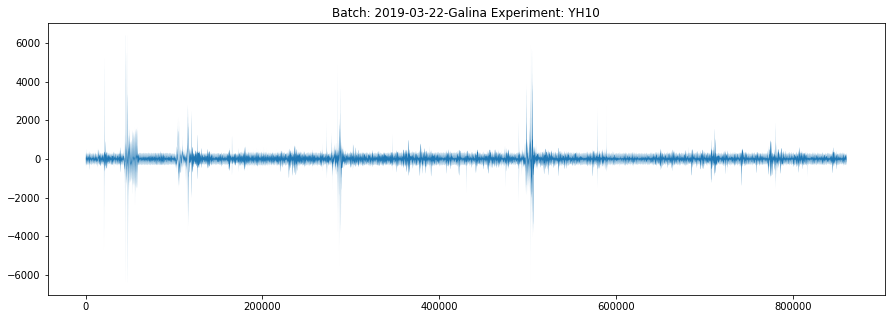

In [469]:
url = "{}/features/overviews/{}/{}.npy".format(
    braingeneers.datasets.get_archive_url(), batch_uuid, experiment["name"])
print("Loading experiment over view from:\n{}".format(url))
overview = np.load(np.DataSource(None).open(url, "rb"))

# Plot the overview
plt.figure(figsize=(15,5))
plt.title("Batch: {} Experiment: {}".format(batch_uuid, experiment["name"]))
plt.fill_between(range(0, overview.shape[0]), overview[:,0], overview[:,1])
plt.show()

In [447]:
X, t, fs = braingeneers.datasets.load_blocks(experiment, 0, 1)
print(X.dtype)
print(X[0:2,:5])
print(X[0:2,-5:])

float32
[[ -87.16499   -99.45      -97.30499  -105.494995 -104.715   ]
 [ -59.67      -71.759995  -83.265     -74.1       -63.179996]]
[[ 13.455     13.65       9.75      15.99      19.695   ]
 [-15.405    -15.405    -26.13     -27.689999 -15.209999]]


In [446]:
class ExperimentDataset(torch.utils.data.Dataset):
    """ Return blocks converted to millivolts """
    
    def __init__(self, experiment):
        self.experiment = experiment

    def __len__(self):
        return len(self.experiment["samples"])

    def __getitem__(self, idx):
        X = np.load("/public/groups/braingeneers/archive/{}".format(experiment["samples"][idx]["derived"])) 
        X = np.multiply(experiment["samples"][0]["scaler"],
                        (X.astype(np.float32) - experiment["samples"][0]["offset"]))
        return torch.Tensor(X)
    
    
dataset = ExperimentDataset(experiment=experiment)
block = next(iter(dataset))
print(block.dtype)
print(block[0:2,:5])
print(block[0:2,-5:])

torch.float32
tensor([[ -87.1650,  -99.4500,  -97.3050, -105.4950, -104.7150],
        [ -59.6700,  -71.7600,  -83.2650,  -74.1000,  -63.1800]])
tensor([[ 13.4550,  13.6500,   9.7500,  15.9900,  19.6950],
        [-15.4050, -15.4050, -26.1300, -27.6900, -15.2100]])


In [452]:
dataset = ExperimentDataset(experiment=experiment)
loader = OverlappingWindowedDatasetLoader(dataset, window_size=5, overlap=3)
loader_iter = iter(loader)

print(next(iter(loader_iter))[0:2,:5])
print(next(iter(loader_iter))[0:2,:5])
# windows = [window for window in loader]

tensor([[ -87.1650,  -99.4500,  -97.3050, -105.4950, -104.7150],
        [ -59.6700,  -71.7600,  -83.2650,  -74.1000,  -63.1800]])
tensor([[ -97.3050, -105.4950, -104.7150,  -96.5250,  -99.0600],
        [ -83.2650,  -74.1000,  -63.1800,  -66.6900,  -71.7600]])


In [457]:
overview[0]

array([-295.62    ,  120.704994], dtype=float32)

In [468]:
window = next(iter(OverlappingWindowedDatasetLoader(dataset, window_size=int(fs/1000), overlap=0)))
[torch.min(window), torch.max(window)]

[tensor(-295.6200), tensor(120.7050)]

In [470]:
dataset = ExperimentDataset(experiment=experiment)
loader = OverlappingWindowedDatasetLoader(dataset, window_size=int(fs/1000), overlap=0)
minmax = torch.tensor([[torch.min(window), torch.max(window)] for window in iter(loader)])
minmax[0]

tensor([-295.6200,  120.7050])

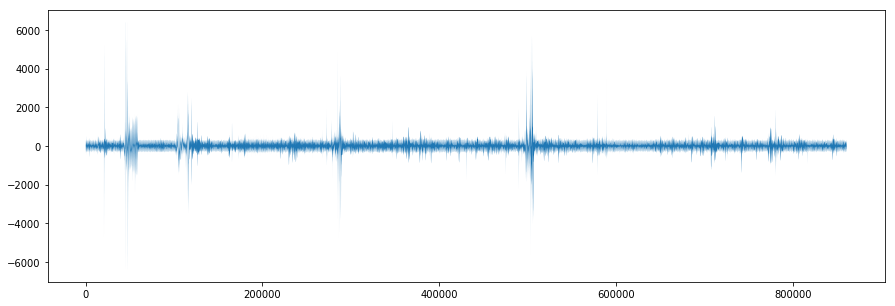

In [471]:
plt.figure(figsize=(15,5))
plt.fill_between(range(0, minmax.shape[0]), minmax[:,0], minmax[:,1])
plt.show()